# Random Forest

In [2]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Model packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from time import time
import pprint
import joblib
from functools import partial

from sklearn.model_selection import KFold, StratifiedKFold

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

# Skopt functions
# conda install -c conda-forge scikit-optimize
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

#display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

path = '/home/jln436/Internship_AUMC/'

In [3]:
# Initialize some variables that will be consistent throughout
n_folds = 5 # For stratified cross-validatio
random_seed = 42
nbins = 10 # For stratified K-fold

In [4]:
# Load training sets
df = pd.read_csv(path + 'output/dfs/X_train_final_minus.csv')
target = pd.read_csv(path + 'output/dfs/y_train_final.csv')

In [5]:
# Remove id number because not useful for predictions
df.drop(columns = ['respnr'], inplace = True)

In [6]:
# Split into training and validation set:
X, X_val, y, y_val = train_test_split(df, target.target, test_size=0.30, random_state=random_seed)
# Stratifying the target
y_stratified = pd.cut(y, bins=nbins, labels=False)

In [7]:
#Scale features
scaler = StandardScaler()
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X), columns = X.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns)

# Bayesian Hyperparameter tuning

In [8]:
# Helpful Links:
## explanation: https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f
## tutorial: https://www.kaggle.com/code/lucamassaron/tutorial-bayesian-optimization-with-lightgbm/notebook

In [9]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params, d

In [10]:
# Setting the scoring function
scoring = make_scorer(partial(mean_squared_error, squared=False), 
                      greater_is_better=False)

In [11]:
# Setting the validation strategy
skf = StratifiedKFold(n_splits=n_folds, 
                      shuffle=True, 
                      random_state=random_seed)

cv_strategy = list(skf.split(X, y_stratified))

In [12]:
# Setting the basic regressor
reg = RandomForestRegressor(verbose = 0,
                            n_jobs = -1, 
                            random_state = random_seed)

In [13]:
# Setting the search space
# max_depth and n_estimators (increase)
search_spaces1 = {
    'n_estimators': Integer(30, 5000),                   # Number of boosted trees to fit
    'criterion': Categorical(['squared_error', 'absolute_error', 'poisson']), # Boosting type
    'max_depth': Integer(1, 500),                       # Maximum tree depth for base learners, <=0 means no limit
    'min_samples_split': Integer(2, 100),                # Minimum number of samples required to split an inner node
    'min_samples_leaf': Integer(1,60),                   # Minimum required number of samples to be in each leaf node
    'min_weight_fraction_leaf': Real(0.01, 0.5, 'uniform'), # The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.
    'max_features': Real(0.01, 1.0, 'uniform'),        # The number of features to consider when looking for the best split:
    'max_leaf_nodes': Integer(2, 256),                  # Maximum number of leaf nodes
    'min_impurity_decrease':  Real(0.01, 1.0, 'log-uniform'), # Minimum decrease in gini impurity
    'bootstrap': Categorical([True]),             # Whether to bootstrap or not
    'oob_score': Categorical([True, False]),             # Whether to use out of bag sampling
    'warm_start': Categorical([True, False]),            # Whether to use warm start
    'ccp_alpha': Real(0.01, 1.0, 'log-uniform'),         # Complexity parameter used for Minimal Cost-Complexity Pruning
    'max_samples': Real(0.01, 1.0, 'uniform'),           # Probably will give issues, because only works when bootstrap is true :(
   }

search_spaces2 = {
    'n_estimators': Integer(30, 5000),                   # Number of boosted trees to fit
    'criterion': Categorical(['squared_error', 'absolute_error', 'poisson']), # Boosting type
    'max_depth': Integer(1, 500),                       # Maximum tree depth for base learners, <=0 means no limit
    'min_samples_split': Integer(2, 100),                # Minimum number of samples required to split an inner node
    'min_samples_leaf': Integer(1,60),                   # Minimum required number of samples to be in each leaf node
    'min_weight_fraction_leaf': Real(0.01, 0.5, 'uniform'), # The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.
    'max_features': Real(0.01, 1.0, 'uniform'),        # The number of features to consider when looking for the best split:
    'max_leaf_nodes': Integer(2, 256),                  # Maximum number of leaf nodes
    'min_impurity_decrease':  Real(0.01, 1.0, 'log-uniform'), # Minimum decrease in gini impurity
    'bootstrap': Categorical([False]),             # Whether to bootstrap or not
    'warm_start': Categorical([True, False]),            # Whether to use warm start
    'ccp_alpha': Real(0.01, 1.0, 'log-uniform')         # Complexity parameter used for Minimal Cost-Complexity Pruning
   }

In [14]:
# Wrapping everything up into the Bayesian optimizer
opt1 = BayesSearchCV(estimator=reg,                                    
                    search_spaces=search_spaces1,                      
                    scoring=scoring,                           
                    cv=cv_strategy,                                           
                    n_iter=50,                                        # max number of trials
                    n_points=3,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=-1,                                        # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability

opt2 = BayesSearchCV(estimator=reg,                                    
                    search_spaces=search_spaces2,                      
                    scoring=scoring,                           
                    cv=cv_strategy,                                           
                    n_iter=50,                                        # max number of trials
                    n_points=3,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=-1,                                        # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability

In [15]:
# Running the optimizer
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 60 * 7) # We impose a time limit (7 hours)

best_params1, d1 = report_perf(opt1, X, y,'RF_regression', 
                          callbacks=[overdone_control, time_limit_control])

best_params2, d2 = report_perf(opt2, X, y,'RF_regression', 
                          callbacks=[overdone_control, time_limit_control])

RF_regression took 312.49 seconds,  candidates checked: 50, best CV score: -5.716 ± 0.554
Best parameters:
OrderedDict([('bootstrap', True),
             ('ccp_alpha', 0.0771981800536835),
             ('criterion', 'squared_error'),
             ('max_depth', 281),
             ('max_features', 0.7118661989961341),
             ('max_leaf_nodes', 203),
             ('max_samples', 1.0),
             ('min_impurity_decrease', 0.905871069159507),
             ('min_samples_leaf', 13),
             ('min_samples_split', 8),
             ('min_weight_fraction_leaf', 0.024178332028684107),
             ('n_estimators', 4355),
             ('oob_score', False),
             ('warm_start', True)])

RF_regression took 324.07 seconds,  candidates checked: 50, best CV score: -5.757 ± 0.537
Best parameters:
OrderedDict([('bootstrap', False),
             ('ccp_alpha', 0.47256685334923815),
             ('criterion', 'squared_error'),
             ('max_depth', 322),
             ('max_features',

### Evaluate the best parameters

In [16]:
# Make predictions on the validation data set:
# Transferring the best parameters to our basic regressor
model1 = RandomForestRegressor(verbose = 0,
                              n_jobs = -1, 
                              random_state = random_seed,
                              **best_params1)
model1.fit(X, y)
# Make predictions:
y_pred1 = model1.predict(X_val)

In [17]:
# accuracy check
mse1 = mean_squared_error(y_val, y_pred1)
rmse1 = mse1**(0.5)
mae1 = mean_absolute_error(y_val, y_pred1)
print("MAE: %.2f" % mae1)
print("MSE: %.2f" % mse1)
print("RMSE: %.2f" % rmse1) 

MAE: 4.63
MSE: 31.28
RMSE: 5.59


In [18]:
# Make predictions on the validation data set:
# Transferring the best parameters to our basic regressor
model2 = RandomForestRegressor(verbose = 0,
                              n_jobs = -1, 
                              random_state = random_seed,
                              **best_params2)
model2.fit(X, y)
# Make predictions:
y_pred2 = model2.predict(X_val)

In [21]:
# accuracy check
mse2 = mean_squared_error(y_val, y_pred2)
rmse2 = mse2**(0.5)
mae2 = mean_absolute_error(y_val, y_pred2)
print("MAE: %.2f" % mae2)
print("MSE: %.2f" % mse2)
print("RMSE: %.2f" % rmse2) 

MAE: 4.63
MSE: 31.58
RMSE: 5.62


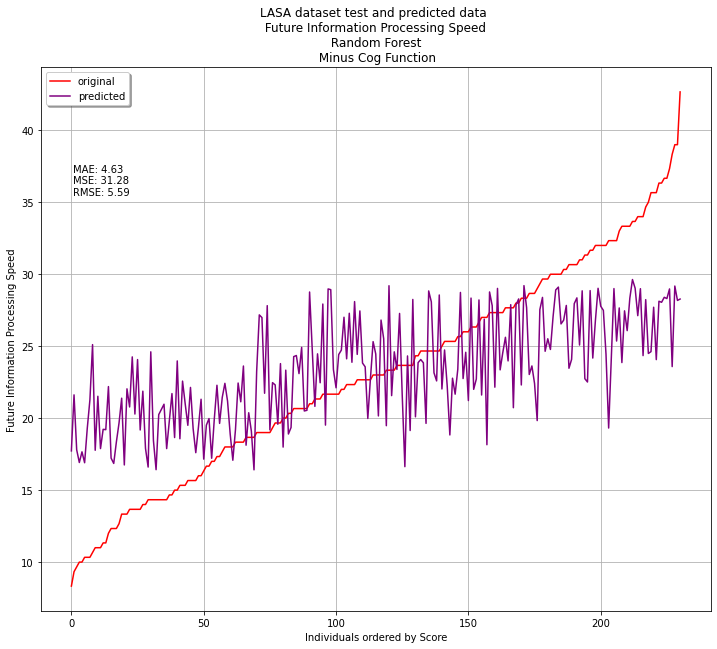

In [22]:
tmp_df = pd.DataFrame(data = y_val)
tmp_df['predicted'] = y_pred1
tmp_df = tmp_df.sort_values(by=['target'])
# visualizing in a plot
x_ax = range(len(y_val))
plt.figure(figsize=(12, 10))
plt.plot(x_ax, tmp_df.target, label="original", color = "red")
plt.plot(x_ax, tmp_df.predicted, label="predicted", color = "purple")
plt.title("LASA dataset test and predicted data \n Future Information Processing Speed \n Random Forest \n Minus Cog Function")
plt.xlabel('Individuals ordered by Score')
plt.ylabel('Future Information Processing Speed')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.text(0.5, 35.5, 'MAE: ' + str(round(mae1,2)) + '\nMSE: ' + str(round(mse1,2)) + '\nRMSE: ' + str(round(rmse1,2)), fontsize = 10)
plt.show()

## Save Training Model

In [23]:
import pickle
filename = path + '/output/models/RF_bayesian_training_model_no_cog_tests.sav'

In [24]:
# save the model to disk
pickle.dump(model1, open(filename, 'wb'))

In [25]:
# load the model from disk
model = pickle.load(open(filename, 'rb'))


## Model Importances

In [26]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

In [27]:
forest_importances = pd.DataFrame(data = X.columns.values.tolist(), columns = ['features'])
forest_importances['importance'] = importances

forest_importances.sort_values('importance', inplace = True, ascending = False)

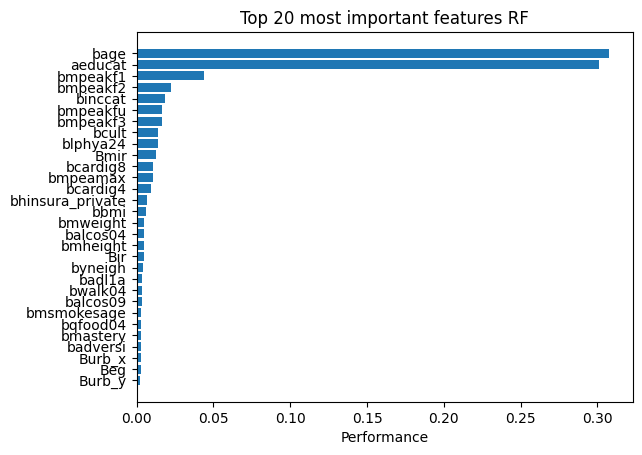

In [28]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(30)

ax.barh(y_pos, forest_importances.importance[0:30], align='center')
ax.set_yticks(y_pos, labels=forest_importances.features[0:30])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('Top 20 most important features RF')

plt.show()

In [29]:
# Save feature importance
forest_importances.to_csv(path + 'output/Importances/RF_Importances_no_cog_tests.csv', index = False)